In [30]:
#!pip install nltk

In [8]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
nltk.download('popular')
# Compare to tokens with no cleaning
# df_tokens = pd.DataFrame.from_dict(nltk.FreqDist(tokens), orient='index')
# df_tokens.columns = ['Frequency']
# df_tokens.index.name = 'Term'

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

# Init exploration about reviews table and normalize rate on 100

In [10]:
link = "./rotten_tomatoes_critic_reviews.csv"
link2 ='./rotten_tomatoes_movies.csv'
# method to convert format rate 3/5 to float
def get_score(rate):
    if type(rate) == str:
        r = rate.split("/")[0]
        if len(r) > 0:
            return float(r)
        
critic_reviews = pd.read_csv(link, converters={'review_date': pd.to_datetime})
movies = pd.read_csv(link2, converters={'original_release_date': pd.to_datetime, 'streaming_release_date': pd.to_datetime})

In [11]:
critic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   rotten_tomatoes_link  1130017 non-null  object        
 1   critic_name           1111488 non-null  object        
 2   top_critic            1130017 non-null  bool          
 3   publisher_name        1130017 non-null  object        
 4   review_type           1130017 non-null  object        
 5   review_score          824081 non-null   object        
 6   review_date           1130017 non-null  datetime64[ns]
 7   review_content        1064211 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(6)
memory usage: 61.4+ MB


In [12]:
critic_reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [13]:
def get_score(x):
    x = x.replace(" ", "")
    letters = {"A":14, "B":11, "C":8,"D":5,"E":2, "F":0}
        #convert string "3.4/5" or "67/100" to rate on 100
    if (type(x)==str) and ('/' in x) and (float(x.split("/")[1]) > float(x.split("/")[0])):
        return 100*(float(x.split("/")[0]) / float(x.split("/")[1]))
    elif x[0] in letters.keys():
        #convert letters rate to rate on 100
        return 100*((letters[x[0]] + 44 - ord(x[1]) if len(x)>1 and x[1] in "-+" else letters[x[0]])/15)

critic_reviews["review_score_float"] = critic_reviews[critic_reviews["review_score"].isna()==False]["review_score"].apply(get_score)
critic_reviews[critic_reviews["review_score_float"].isna()==False]["review_score_float"]

3          70.000000
6          25.000000
7          70.000000
8          73.333333
9          60.000000
             ...    
1130012    40.000000
1130013    70.000000
1130014    80.000000
1130015    70.000000
1130016    53.333333
Name: review_score_float, Length: 777569, dtype: float64

In [14]:
critic_reviews[(critic_reviews["review_score"].isna() != True) | (critic_reviews["review_score_float"].isna() != True)][["review_score", "review_score_float"]]

,review_score,review_score_float
3,3.5/5,70.000000
6,1/4,25.000000
7,3.5/5,70.000000
8,B,73.333333
9,3/5,60.000000
...,...,...
1130012,2/5,40.000000
1130013,3.5/5,70.000000
1130014,B+,80.000000
1130015,3.5/5,70.000000


In [15]:
critic_reviews.describe()

,review_score_float
count,777569.000000
mean,61.542096
std,19.459735
min,0.000000
25%,50.000000
50%,62.500000
75%,80.000000
max,99.900000


In [16]:
# Check why value max is 900
critic_reviews[critic_reviews["review_score_float"] > 100]

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_score_float


# Analyse movie table and compare rate from audience and tomatoemeter

In [17]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rotten_tomatoes_link              17712 non-null  object        
 1   movie_title                       17712 non-null  object        
 2   movie_info                        17391 non-null  object        
 3   critics_consensus                 9134 non-null   object        
 4   content_rating                    17712 non-null  object        
 5   genres                            17693 non-null  object        
 6   directors                         17518 non-null  object        
 7   authors                           16170 non-null  object        
 8   actors                            17360 non-null  object        
 9   original_release_date             16546 non-null  datetime64[ns]
 10  streaming_release_date            17328 non-nu

In [18]:
movies.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


In [19]:
movies.head(3)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8


In [20]:
#movies.drop("diff_rate_audience_tomatometter", axis=1, inplace=True)
movies["diff_rate_audience_tomatometter"] = movies[movies['critics_consensus'].isna() != True]["audience_rating"] - movies[movies['critics_consensus'].isna() != True]["tomatometer_rating"]
movies[movies['diff_rate_audience_tomatometter'].isna() != True].sort_values(by=['diff_rate_audience_tomatometter'], ascending=False)[["movie_info","critics_consensus", "audience_rating","tomatometer_rating", "diff_rate_audience_tomatometter"]]
#movies.info()

,movie_info,critics_consensus,audience_rating,tomatometer_rating,diff_rate_audience_tomatometter
7760,Filmmaker Dinesh D'Souza examines presidential...,Hillary's America: The Secret History of the D...,80.0,4.0,76.0
11487,"Combining outrageous, sexy comedy with the hot...","A party movie that substitutes surfs for snow,...",84.0,8.0,76.0
13916,"Kicked out by his parents, a gay teenager (Jer...","As an ordinary coming-of-age drama, Stonewall ...",85.0,9.0,76.0
2619,"Political commentator, author and filmmaker Di...","Passionate but poorly constructed, America pre...",84.0,8.0,76.0
10504,"In early 20th-century Paris, Pablo Picasso (Om...",Nearly everyone is miscast in this disjointed ...,78.0,4.0,74.0
...,...,...,...,...,...
2330,Awkward teen Adam spends his last high school ...,Much like its well-meaning but clueless protag...,8.0,74.0,-66.0
2710,Amy Schumer gives a refreshingly honest and hi...,Amy Schumer's standup matures in an hour fille...,9.0,79.0,-70.0
7452,NaN,Hannah Gadsby: Nanette brilliantly moves moder...,25.0,100.0,-75.0
9079,"A young bartender in the Bronx, a coal miner's...",A galvanizing glimpse behind the scenes of a p...,20.0,99.0,-79.0


In [21]:
pd.pivot_table(movies, index = ["audience_status", 'tomatometer_status'], values=["tomatometer_rating","tomatometer_count","audience_rating","audience_count", "diff_rate_audience_tomatometter"])

audience_count  audience_rating  \
audience_status tomatometer_status                                    
Spilled         Certified-Fresh      497924.536023        50.435159   
                Fresh                 49059.782410        46.846975   
                Rotten               111214.941325        38.883369   
Upright         Certified-Fresh      371180.449051        79.886859   
                Fresh                 60322.781666        76.433233   
                Rotten               149396.394149        70.638490   

                                    diff_rate_audience_tomatometter  \
audience_status tomatometer_status                                    
Spilled         Certified-Fresh                          -31.379412   
                Fresh                                    -21.308411   
                Rotten                                    10.081733   
Upright         Certified-Fresh                           -8.056252   
                Fresh                                     -2.283197   
                Rotten                                    29.671518   

                                    tomatometer_count  tomatometer_rating  
audience_status tomatometer_status                                         
Spilled         Certified-Fresh            112.000000           81.766571  
                Fresh                       34.993391           73.514489  
                Rotten                      50.378870           30.025738  
Upright         Certified-Fresh            119.510190           87.966268  
                Fresh                       31.530056           82.334908  
                Rotten                      54.920787           39.137161

# Analyse with NLKT the consens comment

In [22]:
X = movies[movies['critics_consensus'].isna() == False]['critics_consensus'].apply(lambda sentence: [w.lower() for w in nltk.word_tokenize(sentence)])
freq = nltk.FreqDist(X.sum())

In [23]:
X_clean = X.apply(lambda tokens: \
                  [ w for w in tokens if w.lower() not in nltk.corpus.stopwords.words("english") ])
freq_clean = nltk.FreqDist(X_clean.sum())

In [24]:
# Compare to tokens with no cleaning
df_tokens = pd.DataFrame.from_dict(freq, orient='index')
df_tokens.columns = ['Frequency']
df_tokens.index.name = 'Term'
# CHange the fred to DataFrame
df_words = pd.DataFrame.from_dict(freq_clean, orient='index')
df_words.columns = ['Frequency']
df_words.index.name = 'Term'

#fig = plt.subplots(figsize=(13,13))

#ax1 = plt.subplot(2,2,1)
#ax2 = plt.subplot(2,2,2)

#df_tokens.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax1)
#ax1.set(title="Tokens with stops words")
#df_words.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax2)
#ax2.set(title="Tokens cleaned")

In [25]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
X_stem = X_clean.apply(lambda words: [porter.stem(word.lower()) for word in words] )
# change to dataFrame to see better final results
df_stem = pd.DataFrame.from_dict(nltk.FreqDist(X_stem.sum()), orient='index')
df_stem.columns = ['Frequency']
df_stem.index.name = 'Term'
#df_stem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar")

In [39]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

X_lem = X_clean.apply(lambda words: [wnl.lemmatize(word.lower()) for word in words] )
# change to dataFrame to see better final results

df_lem = pd.DataFrame.from_dict(nltk.FreqDist(X_lem.sum()), orient='index')
df_lem.columns = ['Frequency']
df_lem.index.name = 'Term'
#X_lem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar")

[Text(0.5, 1.0, 'Lemmatized text')]

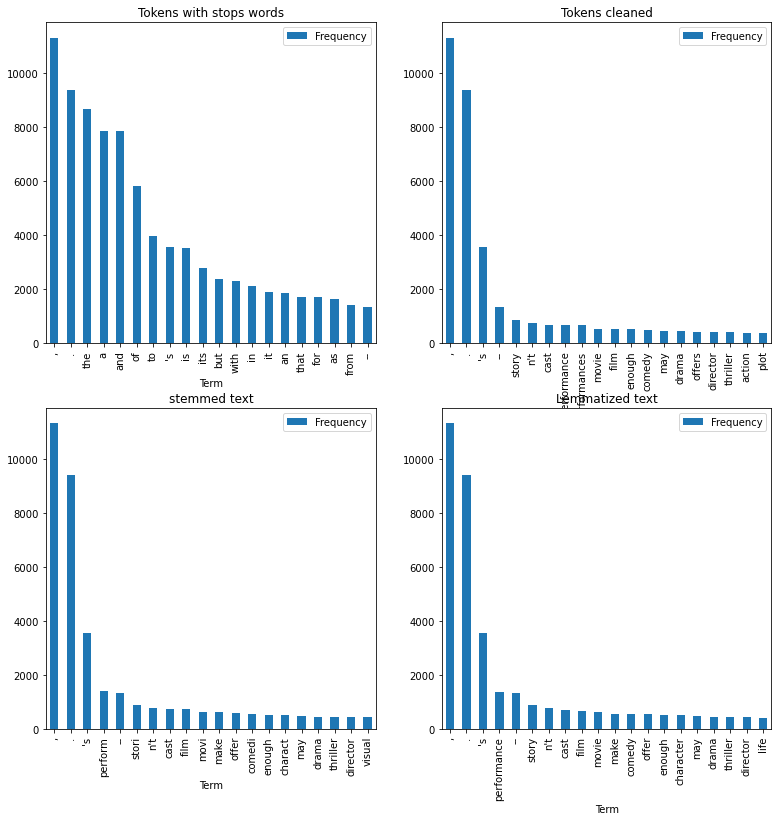

In [36]:
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

#initial text
df_tokens.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax1)
ax1.set(title="Tokens with stops words")

#after cleaning up stopwords and punctuation
df_words.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax2)
ax2.set(title="Tokens cleaned")

#cleaning up stopwords and punctuation + stemmer
df_stem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax3)
ax3.set(title="stemmed text")

#after cleaning up stopwords and punctuation + lemmatizer.
df_lem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax4)
ax4.set(title="Lemmatized text")


In [28]:
#!conda install -c conda-forge gcc
#!conda install -c conda-forge wordcloud 
# or in command terminal
#import sys
#print(sys.executable)


[Text(0.5, 1.0, 'Lemmatized text')]

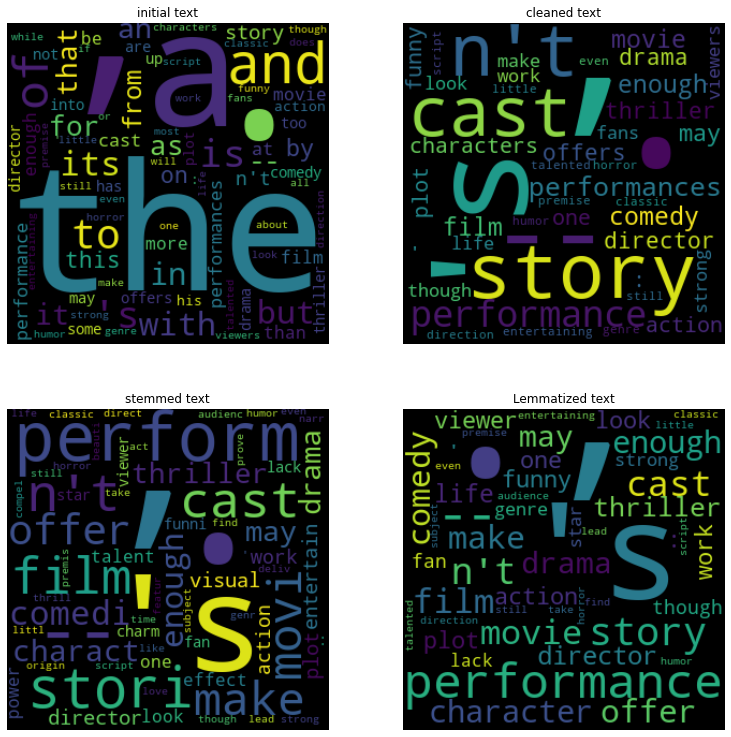

In [41]:
from wordcloud import WordCloud
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

#initial text
wordcloud1 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud1.generate_from_frequencies(freq)

ax1.imshow(wordcloud1, interpolation="bilinear")
ax1.axis('off')
ax1.set(title="initial text")
plt.margins(x=0, y=0)

#after cleaning up stopwords and punctuation
wordcloud2 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud2.generate_from_frequencies(freq_clean)

ax2.imshow(wordcloud2, interpolation="bilinear")
ax2.axis('off')
ax2.set(title="cleaned text")

#cleaning up stopwords and punctuation + stemmer
wordcloud3 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud3.generate_from_frequencies(nltk.FreqDist(X_stem.sum()))

ax3.imshow(wordcloud3, interpolation="bilinear")
ax3.axis('off')
ax3.set(title="stemmed text")

#after cleaning up stopwords and punctuation + lemmatizer.
wordcloud4 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud4.generate_from_frequencies(nltk.FreqDist(X_lem.sum()))

ax4.imshow(wordcloud4, interpolation="bilinear")
ax4.axis('off')
ax4.set(title="Lemmatized text")


In [44]:
#!pip install sklearn

     |████████████████████████████████| 8.0 MB 3.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=77b584b111b3fce03267d80cd98a69bfce1724bb290b3210f4386dfa8704a4ab
  Stored in directory: /Users/fabien/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


# Create a matrix with vectorise of any alpha word longer than 2 caracters

In [113]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern="([a-zA-Z]{2,})")
#vectorizer = CountVectorizer()
X = X_clean.apply(lambda wlist: " ".join(wlist))
vectorizer.fit(X.values)
text_matrix = vectorizer.fit_transform(X)

In [99]:
vectorizer.get_feature_names_out()

array(['a', 'aaliyah', 'aardman', ..., 'zulu', 'zwick', 'zwigoff'],
      dtype=object)

In [100]:
text_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

<AxesSubplot:>

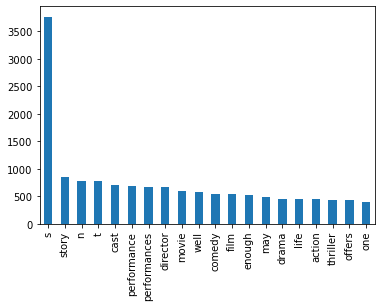

In [111]:
df_matrix = pd.DataFrame(text_matrix.toarray())
df_matrix.columns = vectorizer.get_feature_names_out()
df_matrix.sum().sort_values(ascending=False).head(20).plot(kind="bar")

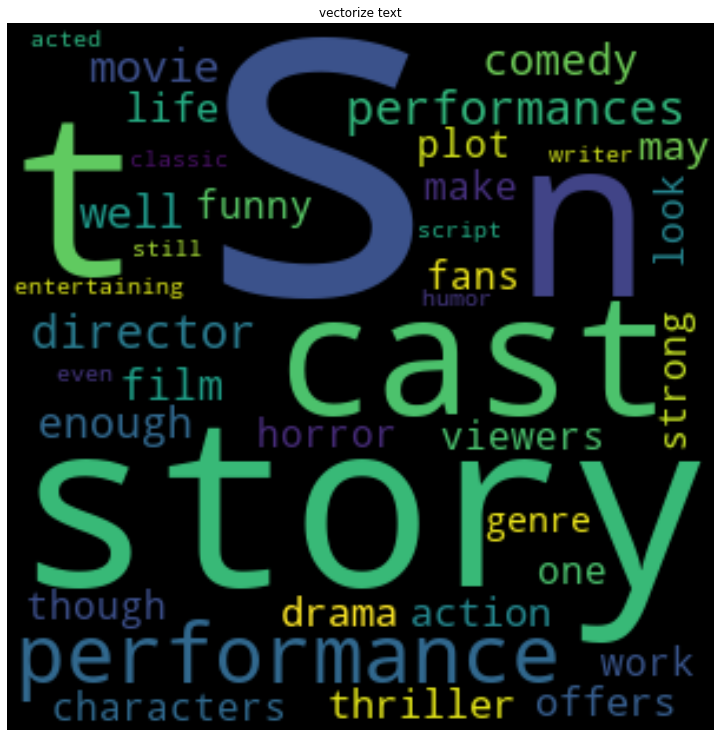

In [110]:
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot()

#initial text
wordcloud = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud.generate_from_frequencies(df_matrix.sum().sort_values(ascending=False).head(40))

ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
ax1.set(title="vectorize text")
plt.margins(x=0, y=0)